In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

2024-11-28 08:05:15.275660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np

TS = 48 # Time steps
FEATURE = 'GC'

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df.head()

Customer             1                    3                 4           \
categories            GG      GC      CL   GG      GC   CL   GG     GC   
2012-07-01 00:30:00  0.0  1710.0  2500.0  0.0  1930.0  0.0  0.0  168.0   
2012-07-01 01:00:00  0.0  1572.0  2500.0  0.0  1854.0  0.0  0.0  168.0   
2012-07-01 01:30:00  0.0  1208.0  2500.0  0.0  2718.0  0.0  0.0  164.0   
2012-07-01 02:00:00  0.0  1088.0  2526.0  0.0   120.0  0.0  0.0  168.0   
2012-07-01 02:30:00  0.0  1194.0   262.0  0.0   118.0  0.0  0.0  172.0   

Customer                     5    ...  297                 298         299  \
categories               CL   GG  ...   GG     GC      CL   GG     GC   GG   
2012-07-01 00:30:00     0.0  0.0  ...  0.0  282.0     0.0  0.0  314.0  0.0   
2012-07-01 01:00:00     0.0  0.0  ...  0.0  514.0     0.0  0.0  254.0  0.0   
2012-07-01 01:30:00  3860.0  0.0  ...  0.0  394.0     0.0  0.0  244.0  0.0   
2012-07-01 02:00:00  3956.0  0.0  ...  0.0  546.0  2660.0  0.0  240.0  0.0   
2012-07-01 02:30:00  1568.0  0.0  ...  0.0  412.0     0.0  0.0  212.0  0.0   

Customer                     300                 
categories               GC   GG     GC      CL  
2012-07-01 00:30:00  1082.0  0.0  438.0  5346.0  
2012-07-01 01:00:00   200.0  0.0  198.0  2492.0  
2012-07-01 01:30:00   180.0  0.0  268.0     0.0  
2012-07-01 02:00:00   188.0  0.0  200.0     0.0  
2012-07-01 02:30:00    92.0  0.0  246.0     0.0  

[5 rows x 725 columns]

In [3]:
customers = sorted(df.columns.levels[0])
max_values = []
for c in customers:
    max_values.append(df[c][FEATURE].max())

normalize = max(max_values)
print(normalize)



13134.0


In [4]:
def gen_data(X, y, num_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - num_steps):        
        Xs.append(np.reshape(X[i:(i + num_steps)], (num_steps, 1)))
        ys.append(y[i + num_steps])
    return np.array(Xs), np.reshape(np.array(ys), (len(ys)))
    
customers = sorted(df.columns.levels[0])
x_list = []
y_list = []
for c in customers[:18]:
    tmp = df[c][FEATURE].to_numpy()/normalize
    tmp_x, tmp_y = gen_data(tmp, tmp, TS)        
    x_list.append(tmp_x)
    y_list.append(tmp_y)
x_data = np.array(x_list)
y_data = np.array(y_list)
print(x_data.shape, y_data.shape)


(18, 17472, 48, 1) (18, 17472)


In [5]:
NT = 15
x_train, y_train = x_data[:NT], y_data[:NT]
print(x_train.shape, y_train.shape)
x_test, y_test = x_data[NT:], y_data[NT:]
print(x_test.shape, y_test.shape)

(15, 17472, 48, 1) (15, 17472)
(3, 17472, 48, 1) (3, 17472)


In [6]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_train.shape

(15, 17472, 48, 1)

In [7]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

def create_model():
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(x_train.shape[2], x_train.shape[3]), return_sequences=False),
        Dense(4),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
# Create model
model = create_model()
model.summary()

/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,489 (17.54 KB)

 Trainable params: 4,489 (17.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train client models
def train_model(model, x_data, y_data, epochs=1, batch_size=64):
    print(x_data.shape, y_data.shape)
    for x, y in zip(x_data, y_data):
        history = model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=1)
    
    return history

def evaluate_model(model, x_test, y_test):
    total_test_loss = 0.0
    total_test_acc = 0.0
    for x_ev, y_ev in zip(x_test, y_test):
        test_loss, test_acc = model.evaluate(x_ev, y_ev, verbose=0)
        total_test_loss += test_loss
        total_test_acc += test_acc
        print('test loss : ', test_loss)

    print('Total loss : ', total_test_loss, 'Length : ', len(x_test))
    return total_test_loss/(len(x_test)), total_test_acc/(len(y_test))
        
# Learing global model 
def model_learning(num_rounds, x, y):
    # Create global model
    model = create_model()
    model_loss = []
    
    for round in range(num_rounds):
        print(f"Round {round + 1}/{num_rounds}")
        
        # Training client models        
        train_model(model, x, y)
        
        # Evaluate Global model
        # test_loss, test_acc = global_model.evaluate(x_test[0], y_test[0], verbose=0)
        test_loss, test_acc = evaluate_model(model, x_test, y_test)
        model_loss.append(test_loss)
        print(f'Model test loss: {test_loss:f}')
        
        # Show prediction with a random sample 
        num_samples = x_test.shape[0]
        test_index = np.random.randint(num_samples)

        plt.figure(figsize=(12, 6))

        y_pred = model.predict(x_test[test_index])
        plt.plot(y_test[test_index][:48*5], marker='.', label='True')
        plt.plot(y_pred[:48*5], 'r', label='Prediction')
        plt.title(f"Model")
        plt.axis('off')

        plt.show()

    return model, model_loss

(3, 17472, 48, 1) (3, 17472)
Round 1/5
(15, 17472, 48, 1) (15, 17472)
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 2.5738e-04 - loss: 0.0022
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 4.7350e-05 - loss: 4.9489e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 3.5401e-04 - loss: 6.3457e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 5.2946e-05 - loss: 7.9783e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.3796e-04 - loss: 0.0012
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 4.3646e-04 - loss: 4.2821e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 2.2966e-04 - loss: 0.0021
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1721 - loss: 8.4194e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 6.0147e-05 - loss: 4.8511e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 1.0966e-04 - loss: 0.0010
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 4.3635e-05 - loss: 2.8626e-04
273/273 ━━━━━━━━━━━━━━━━━

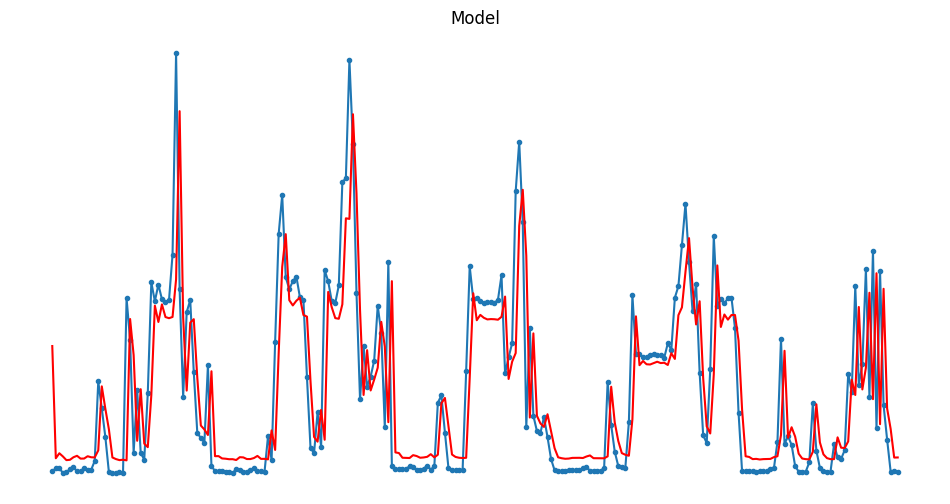

Round 2/5
(15, 17472, 48, 1) (15, 17472)
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 5.4135e-04 - loss: 0.0018
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 2.1799e-04 - loss: 4.0350e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 3.8008e-04 - loss: 4.5333e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 8.4558e-05 - loss: 8.3032e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 1.1373e-04 - loss: 0.0011
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 2.3945e-04 - loss: 4.7988e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 2.4386e-04 - loss: 0.0020
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1675 - loss: 7.9152e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 1.0112e-04 - loss: 4.9276e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 1.3789e-04 - loss: 0.0010
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 4.1631e-05 - loss: 3.0602e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 1

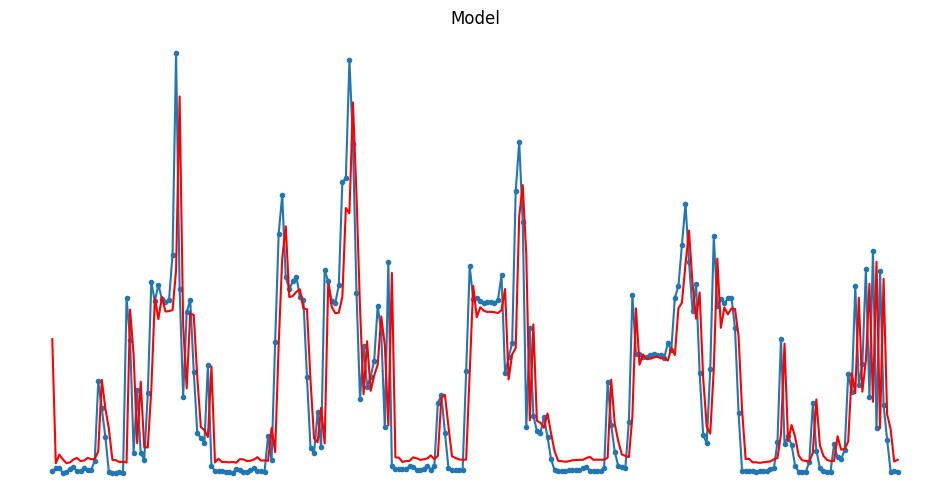

Round 3/5
(15, 17472, 48, 1) (15, 17472)
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 5.0210e-04 - loss: 0.0017
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 3.7365e-05 - loss: 4.3895e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 3.5369e-04 - loss: 4.3297e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 5.5272e-05 - loss: 8.0206e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 1.5816e-04 - loss: 0.0012
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 2.0514e-04 - loss: 4.5103e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 3.1581e-05 - loss: 0.0020
273/273 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.1680 - loss: 7.3549e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.9989e-04 - loss: 4.8303e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 7.5488e-05 - loss: 0.0010
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 1.9403e-04 - loss: 2.8607e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy:

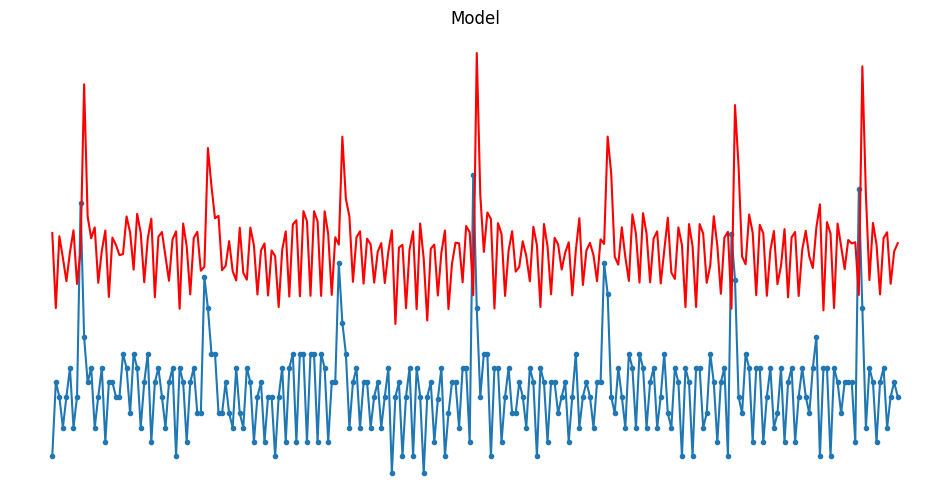

Round 4/5
(15, 17472, 48, 1) (15, 17472)
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 6.1754e-04 - loss: 0.0017
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 1.0855e-04 - loss: 4.0729e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 4.3521e-04 - loss: 5.1344e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 1.3515e-04 - loss: 7.0473e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 1.1782e-04 - loss: 0.0012
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 3.3429e-04 - loss: 4.3869e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 4.8335e-04 - loss: 0.0020
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1674 - loss: 7.4809e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 2.2365e-05 - loss: 5.0219e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 2.1559e-04 - loss: 9.8957e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 2.7279e-04 - loss: 2.8295e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accurac

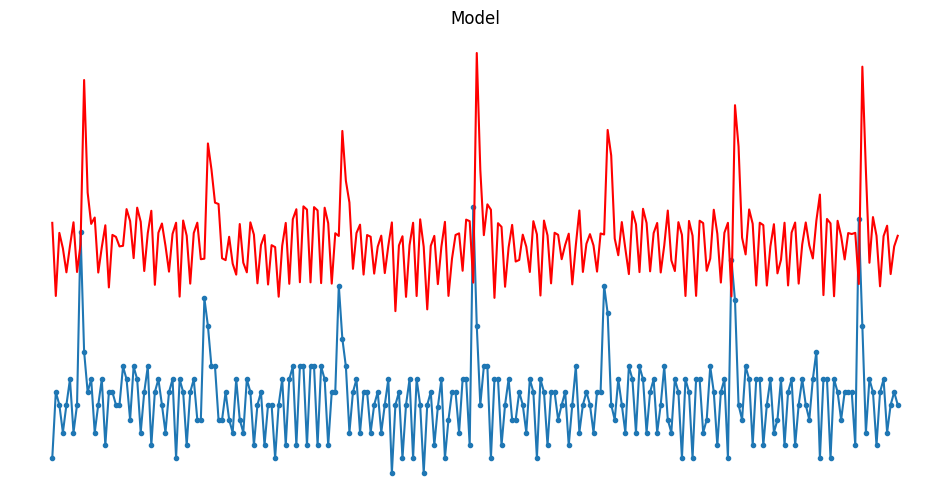

Round 5/5
(15, 17472, 48, 1) (15, 17472)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 5.6749e-04 - loss: 0.0018
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 4.3434e-05 - loss: 3.6672e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 3.7966e-04 - loss: 4.0405e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 8.3305e-05 - loss: 7.2594e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.9224e-04 - loss: 0.0011
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 8.6801e-05 - loss: 4.3954e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 1.9756e-04 - loss: 0.0019
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1641 - loss: 7.7735e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 1.8669e-05 - loss: 4.8370e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 1.9903e-04 - loss: 9.6207e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 6.2896e-05 - loss: 3.0168e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accurac

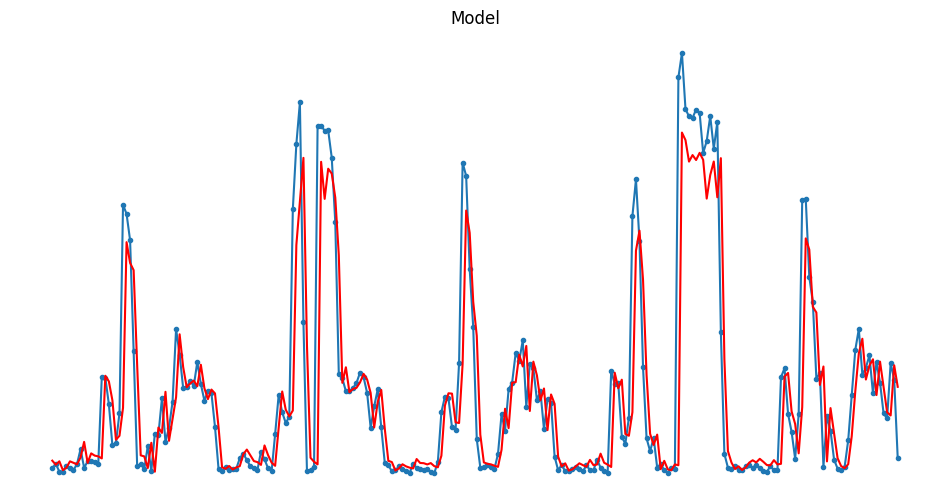

In [10]:
print(x_test.shape, y_test.shape)

# Running federated learning
num_rounds = 5
model, model_loss = model_learning(num_rounds, x_train, y_train)

test loss :  0.00174148625228554
test loss :  0.0008078869432210922
test loss :  0.0002834899059962481
Total loss :  0.0028328631015028805 Length :  3
Final model test loss: 0.000944


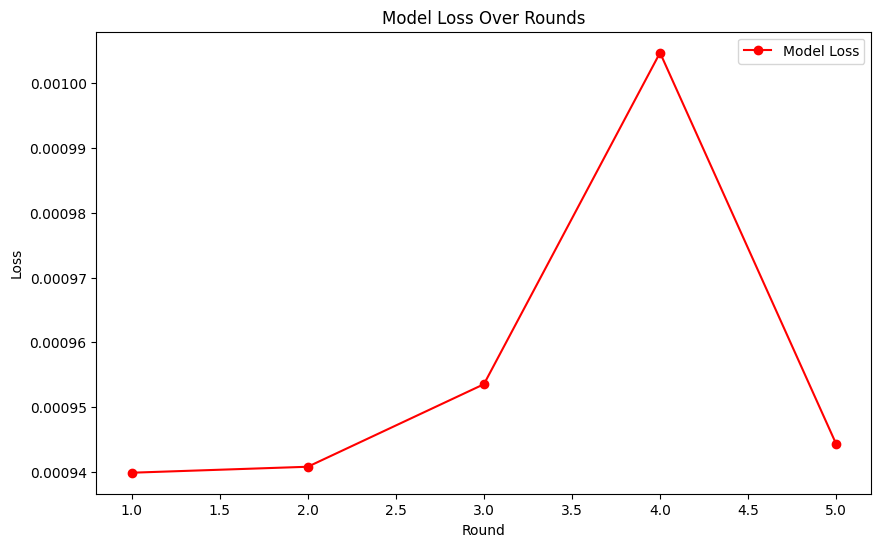

In [11]:
# Evaluate global model
# test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)
test_loss, test_acc = evaluate_model(model, x_test, y_test)
print(f'Final model test loss: {test_loss:f}')

# Show loss of global model for each stage
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), model_loss, 'r-o', label='Model Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Model Loss Over Rounds')
plt.legend()
plt.show()

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


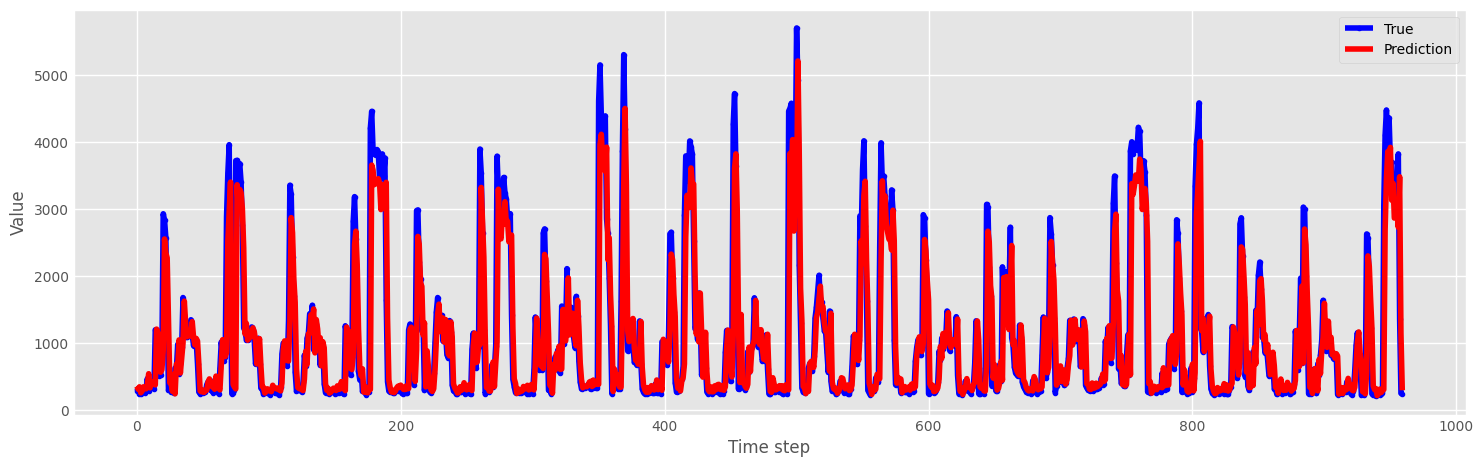

In [ ]:
y_pred = model.predict(x_test[0])
plt.figure(figsize=(16, 5))
plt.plot(y_test[0][:48*20]*normalize, 'b', marker='.', label='True')
plt.plot(y_pred[:48*20]*normalize, 'r', label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time step')
plt.legend()
plt.show()


546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
(960,) 960


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1374/1353627838.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min(x), max(x))


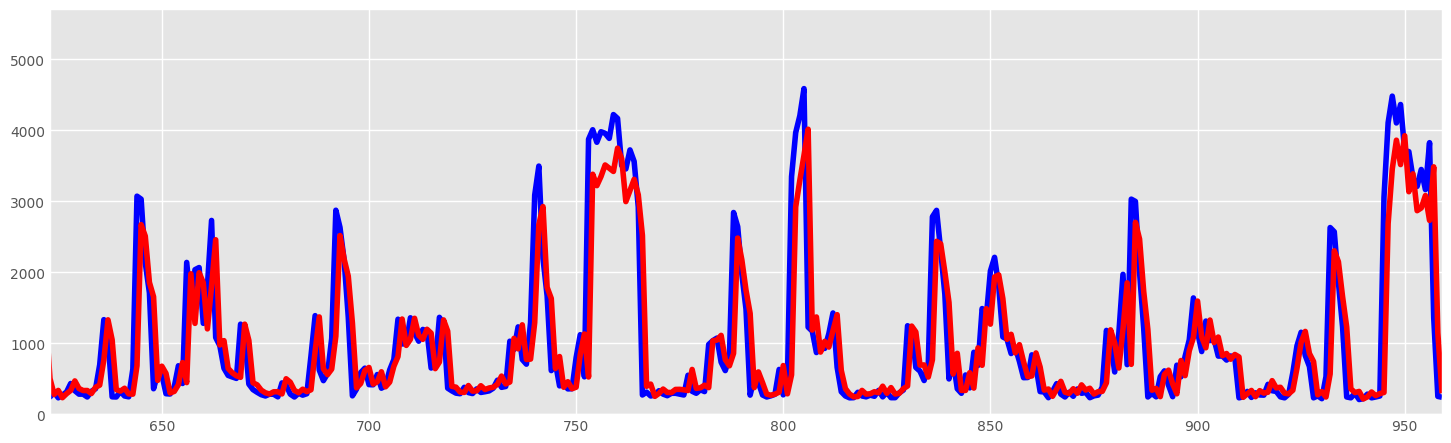

In [106]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

len_disp = 48*20
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
y_pred = model.predict(x_test[0])
y_pred = y_pred.reshape(y_pred.shape[0])[:len_disp]
x, y1, y2 = [], [], []

y_target =y_test[0][:len_disp]
print(y_target.shape, y_pred.shape[0])
y_max = max(np.max(y_pred) , np.max(y_target))*normalize
x_data = np.linspace(0, y_pred.shape[0], y_pred.shape[0], endpoint=False)
x_max = np.max(x_data)
win_size = 48*7
line1, = ax.plot([], [], 'b', label='True')
line2, = ax.plot([], [], 'r', label='Prediction')

def init():
    line1.set_data([], [])
    ax.set_ylim(0, y_max)
    return line1, line2

def animate(i):
    pos = int(i)
    x.append(i)
    y1.append(y_target[pos]*normalize)
    y2.append(y_pred[pos]*normalize)
    line1.set_data(x, y1)
    line2.set_data(x, y2) 
    if i < win_size:
        ax.set_xlim(min(x), max(x))
    else:
        ax.set_xlim(max(x)-win_size, max(x))
    return line1, line2
    

ani = FuncAnimation(fig, animate, init_func=init, frames=x_data, interval=50, blit=True)
HTML(ani.to_html5_video())

# plt.figure(figsize=(16, 5))
# plt.plot(y_test[0][:48*20]*normalize, marker='.', label='True')
# plt.plot(y_pred[:48*20]*normalize, 'r', label='Prediction')
# plt.ylabel('Value')
# plt.xlabel('Time step')
# plt.legend()
# plt.show()
